In [34]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
image_dir = Path('ResnetDataset')

In [36]:
image_dir

WindowsPath('ResnetDataset')

In [37]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [38]:
[os.path.abspath(filepaths[0]) for filepaths[0] in filepaths ]

['E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_100.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1024.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1040.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1041.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1052.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1053.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1077.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1078.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1084.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1091.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1092.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1093.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1105.jpg',
 'E:\\snatchimages\\ResnetDataset\\Accident_Actual\\set_A_1106.jpg',
 'E:\\snatchimages\\ResnetDataset\\

In [39]:
images.Label.value_counts()

Accident_Actual    271
Snatch_actual      264
Weapons_actual     262
Name: Label, dtype: int64

In [40]:
images

,Filepath,Label
0,ResnetDataset\Accident_Actual\set_A_100.jpg,Accident_Actual
1,ResnetDataset\Accident_Actual\set_A_1024.jpg,Accident_Actual
2,ResnetDataset\Accident_Actual\set_A_1040.jpg,Accident_Actual
3,ResnetDataset\Accident_Actual\set_A_1041.jpg,Accident_Actual
4,ResnetDataset\Accident_Actual\set_A_1052.jpg,Accident_Actual
...,...,...
792,ResnetDataset\Weapons_actual\97.jpg,Weapons_actual
793,ResnetDataset\Weapons_actual\97_videoFrame_1.jpg,Weapons_actual
794,ResnetDataset\Weapons_actual\98.jpg,Weapons_actual
795,ResnetDataset\Weapons_actual\98_videoFrame_1.jpg,Weapons_actual


In [41]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [42]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [43]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 446 validated image filenames belonging to 3 classes.
Found 111 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


In [44]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

In [48]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [49]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=10,
    callbacks=[callbacks])

Epoch 1/10
14/14 [==============================] - 61s 4s/step - loss: 0.5184 - accuracy: 0.8206 - val_loss: 0.1067 - val_accuracy: 0.9730
Epoch 2/10
14/14 [==============================] - 61s 4s/step - loss: 0.0800 - accuracy: 0.9776 - val_loss: 0.0418 - val_accuracy: 0.9820
Epoch 3/10
14/14 [==============================] - 59s 4s/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 67s 5s/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 61s 4s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 56s 4s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 59s 4s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 8/10
14/14 [==

In [53]:
results = model.evaluate(test_images, verbose=1)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

8/8 [==============================] - 22s 3s/step - loss: 0.0631 - accuracy: 0.9833
[0.06305526942014694, 0.9833333492279053]
Test Accuracy: 98.33%


In [54]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

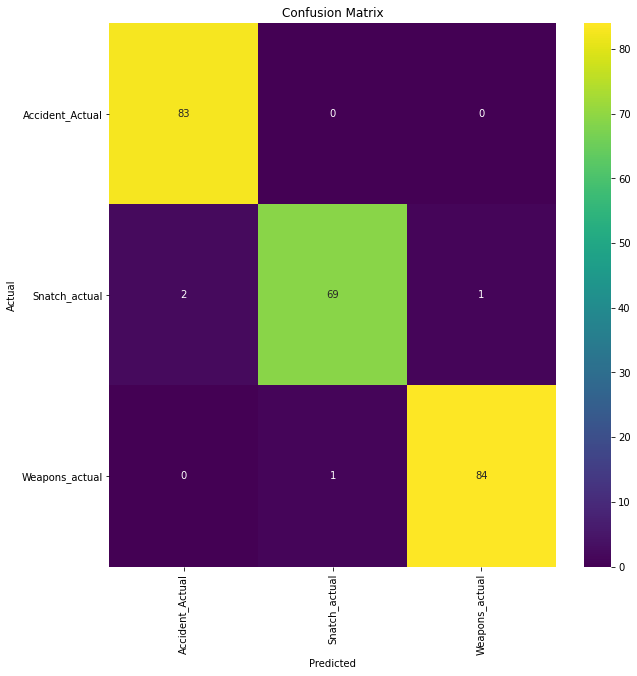

In [57]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(3) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(3) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [58]:
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Accident_Actual       0.98      1.00      0.99        83
  Snatch_actual       0.99      0.96      0.97        72
 Weapons_actual       0.99      0.99      0.99        85

       accuracy                           0.98       240
      macro avg       0.98      0.98      0.98       240
   weighted avg       0.98      0.98      0.98       240



In [59]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,0.518399,0.820628,0.106670,0.972973
1,0.079979,0.977578,0.041839,0.981982
2,0.019850,1.000000,0.015182,1.000000
3,0.009341,1.000000,0.011019,1.000000
4,0.004112,1.000000,0.008138,1.000000
5,0.002514,1.000000,0.007326,1.000000
6,0.001792,1.000000,0.006008,1.000000
7,0.001379,1.000000,0.005557,1.000000
8,0.001122,1.000000,0.004857,1.000000
9,0.000943,1.000000,0.004826,1.000000


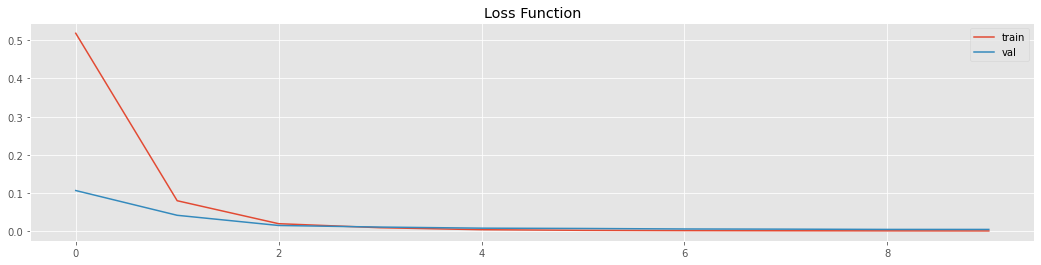

In [60]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)

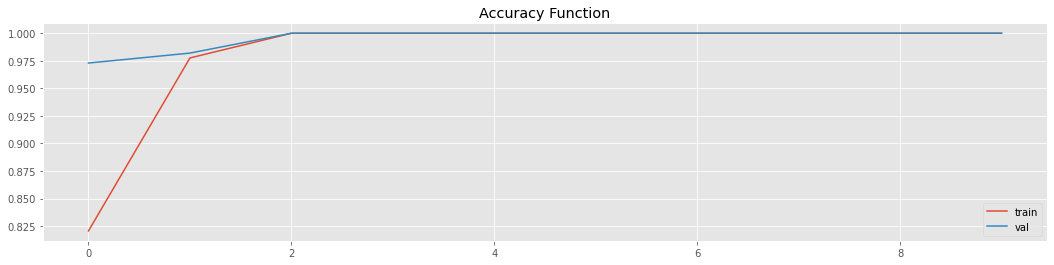

In [61]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [62]:
train_images.class_indices.keys()

dict_keys(['Accident_Actual', 'Snatch_actual', 'Weapons_actual'])

In [63]:
train_images.class_indices.values()

dict_values([0, 1, 2])

In [64]:
df=pd.DataFrame({'names':list(train_images.class_indices.keys()),
                 'index':list(train_images.class_indices.values())})

In [65]:
df.iloc[0]['names']

'Accident_Actual'

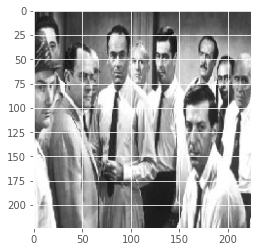

2    Weapons_actual
Name: names, dtype: object


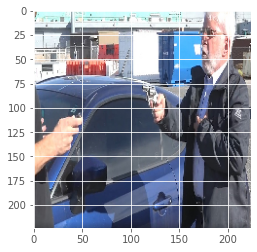

2    Weapons_actual
Name: names, dtype: object


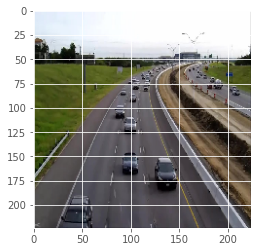

0    Accident_Actual
Name: names, dtype: object


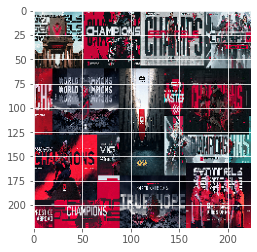

1    Snatch_actual
Name: names, dtype: object


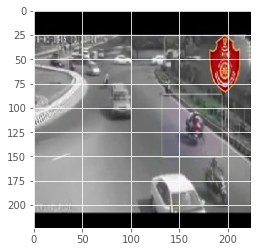

0    Accident_Actual
Name: names, dtype: object


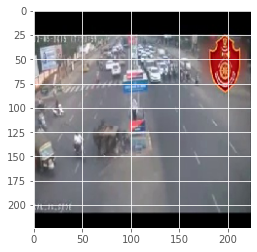

0    Accident_Actual
Name: names, dtype: object


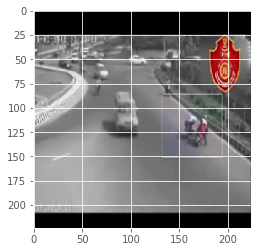

0    Accident_Actual
Name: names, dtype: object


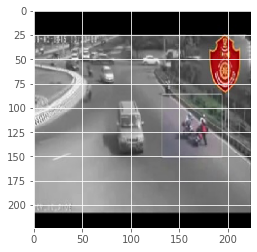

0    Accident_Actual
Name: names, dtype: object


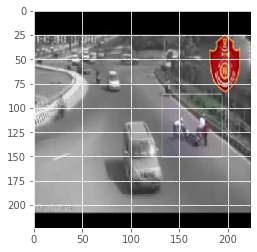

0    Accident_Actual
Name: names, dtype: object


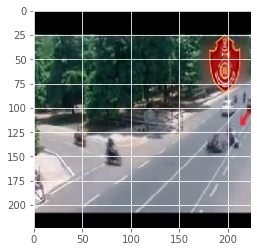

0    Accident_Actual
Name: names, dtype: object


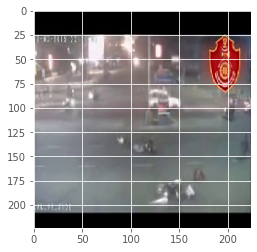

0    Accident_Actual
Name: names, dtype: object


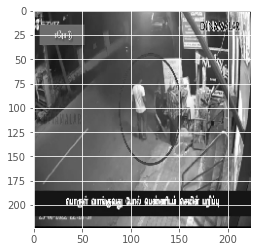

1    Snatch_actual
Name: names, dtype: object


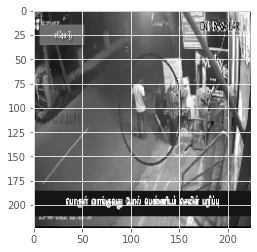

1    Snatch_actual
Name: names, dtype: object


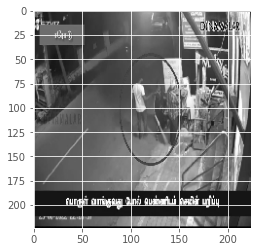

1    Snatch_actual
Name: names, dtype: object


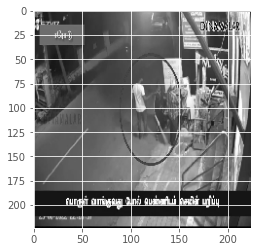

1    Snatch_actual
Name: names, dtype: object


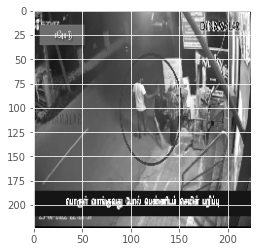

1    Snatch_actual
Name: names, dtype: object


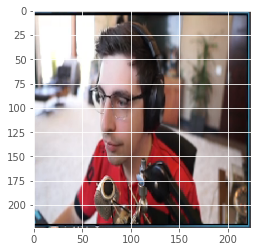

2    Weapons_actual
Name: names, dtype: object


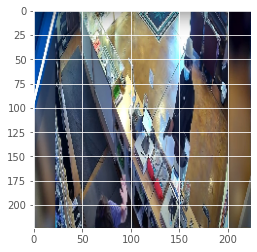

1    Snatch_actual
Name: names, dtype: object


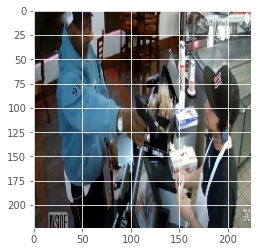

2    Weapons_actual
Name: names, dtype: object


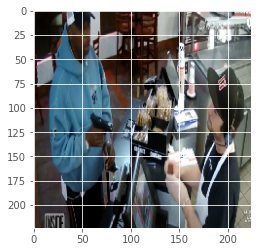

2    Weapons_actual
Name: names, dtype: object


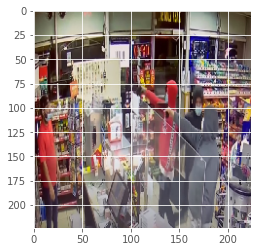

1    Snatch_actual
Name: names, dtype: object


In [84]:
from tensorflow.keras.preprocessing import image
dir_path = 'Resnettest/test/'
for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'/'+i,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis=0)
    images = np.vstack([X])
    predictions = np.argmax(model.predict(images), axis=1)
    print(df.iloc[predictions]['names'])
labeltest['Label'] = test_out

In [98]:
model.save("resnet_model")

INFO:tensorflow:Assets written to: resnet_model\assets


c:\users\shubham zope\appdata\local\programs\python\python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
